# Tranfser Learing

## Packages and Subsidiary Functions

In [ ]:
!pip install pytorch-lightning
!pip install -q pytorch-metric-learning
!pip install facenet-pytorch
!pip install faiss-gpu
!pip install numpy==1.16.2

     |████████████████████████████████| 409kB 6.1MB/s 
     |████████████████████████████████| 829kB 19.9MB/s 
     |████████████████████████████████| 276kB 43.7MB/s 
     |████████████████████████████████| 2.8MB 18.8MB/s 
  Created wheel for future: filename=future-0.18.2-cp36-none-any.whl size=491057 sha256=e2ef55701ecba2bb64eee4517f666b3195be01f51971772f60f4fd8fd87bdf37
  Stored in directory: /root/.cache/pip/wheels/8b/99/a0/81daf51dcd359a9377b110a8a886b3895921802d2fc1b2397e
  Created wheel for PyYAML: filename=PyYAML-5.3.1-cp36-cp36m-linux_x86_64.whl size=44619 sha256=24406f640e32f60421e419ca973490ddc8a8b71e9ca22fe703217bce9d136696
  Stored in directory: /root/.cache/pip/wheels/a7/c1/ea/cf5bd31012e735dc1dfea3131a2d5eae7978b251083d6247bd
Successfully built future PyYAML
ERROR: tensorflow 2.3.0 has requirement tensorboard<3,>=2.3.0, but you'll have tensorboard 2.2.0 which is incompatible.
  Found existing installation: future 0.16.0
    Uninstalling future-0.16.0:
      Successfully 

In [ ]:
import gdown
from google.colab import drive
import os
import shutil
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import random
from tqdm import tqdm
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torch.utils.data.dataset import random_split
from torchvision import datasets, models
from torchvision import transforms
from torchvision.transforms import Compose, ToTensor, Normalize, ToPILImage, Resize, RandomHorizontalFlip, RandomErasing
from pytorch_metric_learning import samplers, miners, losses, regularizers
import tensorboard
import pytorch_lightning as pl
import numpy as np
import json
from pytorch_lightning.callbacks import ModelCheckpoint
from facenet_pytorch import MTCNN, InceptionResnetV1, fixed_image_standardization, training
from google.colab import drive
from tqdm import tqdm 
from sklearn.preprocessing import normalize
from sklearn.cluster import KMeans

from pytorch_metric_learning import losses, miners, distances, reducers, testers
from pytorch_metric_learning.utils.accuracy_calculator import AccuracyCalculator
import torch.optim as optim
import numpy as np
import torch.nn.functional as F

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
assert isinstance(device, torch.device)
print('Running on: {}'.format(device))

Running on: cuda


Class definition of Deep Metric Learing.

In [ ]:
class DeepMetricLearner(pl.LightningModule):

    def __init__(self, myclass, net, embedding_size=128, last_layer_size=128, embedding_size_net=128, margin=0.4, batch_size=128):
        super().__init__()

        self.save_hyperparameters()
        self.embedding_size_net = embedding_size_net
        self.embedding_size = embedding_size
        self.last_layer_size = last_layer_size
        self.batch_size = batch_size
        self.margin = margin
        
        self.net = myclass(net, last_layer_size = self.last_layer_size, embedding_size=self.embedding_size_net)
        self.miner = miners.BatchHardMiner()
        self.loss = losses.TripletMarginLoss(margin=self.margin)

    def forward(self, x):
        return self.net(x.to('cuda')).to('cuda')

    def training_step(self, batch, batch_idx):
        x, labels = batch
        embeddings = self.forward(x)
        triplets = self.miner(embeddings, labels)
        loss = self.loss(embeddings, labels, triplets)
        logs = {'train_loss': loss}
        return {'loss': loss, 'log': logs}

    def validation_step(self, batch, batch_idx):
        x, labels = batch
        embeddings = self.forward(x)
        triplets = self.miner(embeddings, labels)
        loss = self.loss(embeddings, labels, triplets)
        return {'val_loss': loss}        

    def validation_epoch_end(self, outputs):
        avg_loss = torch.stack([x['val_loss'] for x in outputs]).mean()
        tensorboard_logs = {'val_loss': avg_loss}
        return {'avg_val_loss': avg_loss, 'log': tensorboard_logs}

    def prepare_data(self):
      self.train_data = train_data
      self.valid_data = valid_data
      examples_per_class = 2
      self.train_sampler = samplers.MPerClassSampler(labels=self.train_data.idx_to_class, m=examples_per_class, length_before_new_iter=len(self.train_data))
      self.valid_sampler = samplers.MPerClassSampler(labels=self.valid_data.idx_to_class, m=examples_per_class, length_before_new_iter=len(self.valid_data))

    def test_step(self, test_batch, batch_idx):
      pass
    
    def test_epoch_end(self, outputs):
      test_acc_mean = 0
      for output in outputs:
        test_acc_mean += output['acc']

      test_acc_mean /= len(outputs)
      tqdm_dict = {'test_acc': test_acc_mean.item()}

        # show test_loss and test_acc in progress bar but only log test_loss
      results = {
            'progress_bar': tqdm_dict,
            'log': {'test_acc': test_acc_mean.item()}
        }
      return results


    def train_dataloader(self):
        return DataLoader(self.train_data, batch_size=self.batch_size, sampler=self.train_sampler)

    def val_dataloader(self):
        return DataLoader(self.valid_data, batch_size=self.batch_size, sampler=self.valid_sampler)
    
    def test_dataloader(self):
        pass

    def configure_optimizers(self):
        optimizer = torch.optim.SGD(self.parameters(), lr=1e-4)
        return optimizer


early_stop_callback = pl.callbacks.early_stopping.EarlyStopping(
   monitor='val_loss',
   min_delta=0.0,
   patience=2,
   verbose=False,
   mode='min'
)

In [ ]:
def set_checkpoint_callback(filepath:str, save_top_k:int, net_name:str):
  
  checkpoint_callback = ModelCheckpoint(
      filepath=os.path.join(filepath,''),
      save_top_k=save_top_k,
      verbose=True,
      monitor='val_loss',
      mode='min',
      prefix=net_name
  )
  return checkpoint_callback

Functions definitions for evaluation metrices.

In [ ]:
def collate_fn(x):
    return x[0]

In [ ]:
import numpy as np
from sklearn.model_selection import KFold

def evaluate(distances, labels, thresholds_roc_start = 0.1,thresholds_roc_end =1.5,thresholds_roc_step = 0.1, diagonal_excl=True):
    # Calculate evaluation metrics
    thresholds = np.arange(thresholds_roc_start ,thresholds_roc_end ,thresholds_roc_step)
    tpr, fpr, accuracy, best_threshold_index = calculate_roc(thresholds, distances,labels, diagonal_excl)
    plot_roc(fpr, tpr, figure_name="roc.png")
    print('the best accuracy:',  accuracy[best_threshold_index]  ,'True Positive rate:',  tpr[best_threshold_index] ,'False Positive rate:', fpr[best_threshold_index],'threshold:',thresholds[best_threshold_index])
   

def calculate_roc(thresholds, distances, labels, diagonal_excl): 
    nrof_pairs = min(len(labels), len(distances))
    nrof_thresholds = len(thresholds)
    
    tprs = np.zeros((nrof_thresholds))
    fprs = np.zeros((nrof_thresholds))
    
    
    acc = np.zeros((nrof_thresholds))

    for threshold_idx, threshold in enumerate(thresholds):
       tprs[threshold_idx], fprs[threshold_idx], acc[threshold_idx] = calculate_accuracy(threshold, distances, labels,diagonal_excl)
    best_threshold_index = np.argmax(acc)

    return tprs, fprs, acc , best_threshold_index

def calculate_accuracy(threshold, dist, actual_issame, diagonal_excl):
    predict_issame = np.less(dist, threshold)
    if diagonal_excl==True:
      tp = np.sum(np.logical_and(predict_issame, actual_issame))-len(dists)
    else: 
      tp = np.sum(np.logical_and(predict_issame, actual_issame))
    fp = np.sum(np.logical_and(predict_issame, np.logical_not(actual_issame)))
    tn = np.sum(np.logical_and(np.logical_not(predict_issame), np.logical_not(actual_issame)))
    fn = np.sum(np.logical_and(np.logical_not(predict_issame), actual_issame))

    tpr = 0 if (tp + fn == 0) else float(tp) / float(tp + fn)
    fpr = 0 if (fp + tn == 0) else float(fp) / float(fp + tn)
    if diagonal_excl==True:
      acc = float(tp + tn) / (dist.size-len(dists))
    else:  acc = float(tp + tn) / dist.size
    return tpr, fpr, acc


def plot_roc(fpr, tpr, figure_name="roc.png"):
    import matplotlib.pyplot as plt
    plt.switch_backend('Agg')

    from sklearn.metrics import auc
    roc_auc = auc(fpr, tpr)
    fig = plt.figure()
    lw = 2
    plt.plot(fpr, tpr, color='#16a085',
             lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='#2c3e50', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic')
    plt.legend(loc="lower right", frameon=False)
    fig.savefig(figure_name, dpi=fig.dpi)

In [ ]:
def calculate_accuracy_s(threshold, dist, actual_issame): # accuracy - delete dist=0
    predict_issame = np.less(dist, threshold)
    tp = np.sum(np.logical_and(predict_issame, actual_issame))-len(dists)#hd
    fp = np.sum(np.logical_and(predict_issame, np.logical_not(actual_issame)))
    tn = np.sum(np.logical_and(np.logical_not(predict_issame), np.logical_not(actual_issame)))
    fn = np.sum(np.logical_and(np.logical_not(predict_issame), actual_issame))

    tpr = 0 if (tp + fn == 0) else float(tp) / float(tp + fn)
    fpr = 0 if (fp + tn == 0) else float(fp) / float(fp + tn)
    acc = float(tp + tn) / ((len(dists)*len(dists[0]))-len(dists)) #acc = float(tp + tn) / dist.size
    return tp,fp,tn,fn,tpr, fpr, acc

In [ ]:
# def tensor_to_image(x):

#   transform = Compose([Normalize([0., 0., 0.], [1/0.229, 1/0.224, 1/0.225]),
#                        Normalize([-0.485, -0.456, -0.406], std = [1.,1.,1.]),
#                        ToPILImage()])
#   image = transform(x.cpu())
#   return image

Function for displaying a tensor as an image.


In [ ]:
def display_tensor(x, title=None):
   image = tensor_to_image(x)
   plt.imshow(image)
   if title is not None:
      plt.title('ID osoby: {}'.format(title))

## Datasets downloading and praparation for models training

In [ ]:
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


### VGGFace2 sample data for MobileFaceNet model training

In [ ]:
%cp '/content/gdrive/My Drive/VGG_mobile_aligned/train_1_aligned_mobile.zip' '/content'
%cp '/content/gdrive/My Drive/VGG_mobile_aligned/train_2_aligned_mobile.zip' '/content'
%cp '/content/gdrive/My Drive/VGG_mobile_aligned/train_3_aligned_mobile.zip' '/content'
%cp '/content/gdrive/My Drive/VGG_mobile_aligned/train_4_aligned_mobile.zip' '/content'
%cp '/content/gdrive/My Drive/VGG_mobile_aligned/train_5_aligned_mobile.zip' '/content'

In [ ]:
!unzip train_1_aligned_mobile.zip
!unzip train_2_aligned_mobile.zip
!unzip train_3_aligned_mobile.zip
!unzip train_4_aligned_mobile.zip
!unzip train_5_aligned_mobile.zip

!rm train_1_aligned_mobile.zip
!rm train_2_aligned_mobile.zip
!rm train_3_aligned_mobile.zip
!rm train_4_aligned_mobile.zip
!rm train_5_aligned_mobile.zip

Strumieniowane dane wyjściowe obcięte do 5000 ostatnich wierszy.
  inflating: content/train_5_aligned/n002461/0263_01.jpg  
  inflating: content/train_5_aligned/n002461/0082_01.jpg  
  inflating: content/train_5_aligned/n002461/0372_01.jpg  
  inflating: content/train_5_aligned/n002461/0134_01.jpg  
  inflating: content/train_5_aligned/n002461/0242_01.jpg  
  inflating: content/train_5_aligned/n002461/0119_01.jpg  
  inflating: content/train_5_aligned/n002461/0088_01.jpg  
  inflating: content/train_5_aligned/n002461/0198_01.jpg  
  inflating: content/train_5_aligned/n002461/0282_01.jpg  
  inflating: content/train_5_aligned/n002461/0289_01.jpg  
  inflating: content/train_5_aligned/n002461/0083_01.jpg  
  inflating: content/train_5_aligned/n002461/0231_01.jpg  
  inflating: content/train_5_aligned/n002461/0208_03.jpg  
  inflating: content/train_5_aligned/n002461/0317_01.jpg  
  inflating: content/train_5_aligned/n002461/0125_01.jpg  
  inflating: content/train_5_aligned/n002461/0240_

In [ ]:
!mkdir '/content/vgg2_train'
!mkdir '/content/vgg2_test'

%cp -r /content/content/train_1_aligned/* '/content/vgg2_train'
%cp -r /content/content/train_2_aligned/* '/content/vgg2_train'
%cp -r /content/content/train_3_aligned/* '/content/vgg2_train'
%cp -r /content/content/train_4_aligned/* '/content/vgg2_train'

%cp -r /content/content/train_5_aligned/* '/content/vgg2_test'

### Personal Photos

In [ ]:
url = 'https://drive.google.com/uc?export=download&id=1zmRmId5xFU4MRrDZ9j5EgYv5bhFlv1nM'
output = 'faces_folder.zip'
gdown.download(url, output, False)
!unzip -o faces_folder.zip
!rm faces_folder.zip

Downloading...
From: https://drive.google.com/uc?export=download&id=1zmRmId5xFU4MRrDZ9j5EgYv5bhFlv1nM
To: /content/faces_folder.zip
124MB [00:00, 148MB/s] 


Archive:  faces_folder.zip
   creating: Faces_Folder/
   creating: Faces_Folder/DD/
  inflating: Faces_Folder/DD/DD_100_143.jpg  
  inflating: Faces_Folder/DD/DD_100_4850.jpg  
  inflating: Faces_Folder/DD/DD_100_600.jpg  
  inflating: Faces_Folder/DD/DD_100_7510.jpg  
  inflating: Faces_Folder/DD/DD_100_4711.jpg  
  inflating: Faces_Folder/DD/DD_100_1410.jpg  
  inflating: Faces_Folder/DD/DD_100_6550.jpg  
  inflating: Faces_Folder/DD/DD_100_6050.jpg  
  inflating: Faces_Folder/DD/DD_100_1371.jpg  
  inflating: Faces_Folder/DD/DD_100_6570.jpg  
  inflating: Faces_Folder/DD/DD_100_5170.jpg  
  inflating: Faces_Folder/DD/DD_100_1841.jpg  
  inflating: Faces_Folder/DD/DD_100_7250.jpg  
  inflating: Faces_Folder/DD/DD_100_2720.jpg  
  inflating: Faces_Folder/DD/DD_100_3050.jpg  
  inflating: Faces_Folder/DD/DD_100_6590.jpg  
  inflating: Faces_Folder/DD/DD_100_7550.jpg  
  inflating: Faces_Folder/DD/DD_100_4360.jpg  
  inflating: Faces_Folder/DD/DD_100_8900.jpg  
  inflating: Faces_Folder

### LFW

In [ ]:
url = 'https://drive.google.com/uc?id=1vfjmbep7UtbY76j81T0jcF4ePbTw-oMY'
output = 'lfw.tgz'
gdown.download(url, output, False)

Downloading...
From: https://drive.google.com/uc?id=1vfjmbep7UtbY76j81T0jcF4ePbTw-oMY
To: /content/lfw.tgz
181MB [00:02, 62.9MB/s]


'lfw.tgz'

In [ ]:
tar = tarfile.open('lfw.tgz')
tar.extractall()
tar.close()

## Models

### MobileFaceNet

Downloading needed repositories.

In [ ]:
!git clone https://github.com/TreB1eN/InsightFace_Pytorch.git

Cloning into 'InsightFace_Pytorch'...
remote: Enumerating objects: 236, done.
remote: Total 236 (delta 0), reused 0 (delta 0), pack-reused 236
Receiving objects: 100% (236/236), 14.35 MiB | 23.03 MiB/s, done.
Resolving deltas: 100% (118/118), done.


Model downlading.

In [ ]:
%cd '/content/InsightFace_Pytorch'
from model import MobileFaceNet
%cd ..

/content/InsightFace_Pytorch
/content


In [ ]:
url = 'https://drive.google.com/uc?export=download&id=1NofDYM1xnQUopTNMx4Qsieb_XUJ208mo'
output = 'model_mobilefacenet_arcface.pth'
gdown.download(url, output, False)

Downloading...
From: https://drive.google.com/uc?export=download&id=1NofDYM1xnQUopTNMx4Qsieb_XUJ208mo
To: /content/model_mobilefacenet_arcface.pth
4.94MB [00:00, 39.3MB/s]


'model_mobilefacenet_arcface.pth'

In [ ]:
resize = 112
train_data_dir = '/content/vgg2_train'
valid_data_dir = '/content/vgg2_test'

Number of identities in training and validation set.

In [ ]:
import os

def fcount(path):
    count1 = 0
    for root, dirs, files in os.walk(path):
            count1 += len(dirs)

    return print(count1)

fcount(train_data_dir) 
fcount(valid_data_dir) 

1644
411


In [ ]:
img_transformed = Compose([Resize([resize,resize]), ToTensor()])

train_data = datasets.ImageFolder(train_data_dir, transform=img_transformed)
train_data.idx_to_class = {i:c for c, i in train_data.class_to_idx.items()}

valid_data = datasets.ImageFolder(valid_data_dir, transform=img_transformed)
valid_data.idx_to_class = {i:c for c, i in valid_data.class_to_idx.items()}

Model definition.

In [ ]:
url = 'https://drive.google.com/uc?export=download&id=1NofDYM1xnQUopTNMx4Qsieb_XUJ208mo'
output = 'model_mobilefacenet_arcface.pth'
gdown.download(url, output, False)

Downloading...
From: https://drive.google.com/uc?export=download&id=1NofDYM1xnQUopTNMx4Qsieb_XUJ208mo
To: /content/model_mobilefacenet_arcface.pth
4.94MB [00:00, 39.3MB/s]


'model_mobilefacenet_arcface.pth'

In [ ]:
mobilefacenet = MobileFaceNet(embedding_size=512)
mobilefacenet.load_state_dict(torch.load('model_mobilefacenet_arcface.pth'))

<All keys matched successfully>

In [ ]:
for i, (name, params) in enumerate(mobilefacenet.named_parameters()):
  print(i, name)

0 conv1.conv.weight
1 conv1.bn.weight
2 conv1.bn.bias
3 conv1.prelu.weight
4 conv2_dw.conv.weight
5 conv2_dw.bn.weight
6 conv2_dw.bn.bias
7 conv2_dw.prelu.weight
8 conv_23.conv.conv.weight
9 conv_23.conv.bn.weight
10 conv_23.conv.bn.bias
11 conv_23.conv.prelu.weight
12 conv_23.conv_dw.conv.weight
13 conv_23.conv_dw.bn.weight
14 conv_23.conv_dw.bn.bias
15 conv_23.conv_dw.prelu.weight
16 conv_23.project.conv.weight
17 conv_23.project.bn.weight
18 conv_23.project.bn.bias
19 conv_3.model.0.conv.conv.weight
20 conv_3.model.0.conv.bn.weight
21 conv_3.model.0.conv.bn.bias
22 conv_3.model.0.conv.prelu.weight
23 conv_3.model.0.conv_dw.conv.weight
24 conv_3.model.0.conv_dw.bn.weight
25 conv_3.model.0.conv_dw.bn.bias
26 conv_3.model.0.conv_dw.prelu.weight
27 conv_3.model.0.project.conv.weight
28 conv_3.model.0.project.bn.weight
29 conv_3.model.0.project.bn.bias
30 conv_3.model.1.conv.conv.weight
31 conv_3.model.1.conv.bn.weight
32 conv_3.model.1.conv.bn.bias
33 conv_3.model.1.conv.prelu.weight
34

In [ ]:
for i, (name, params) in enumerate(mobilefacenet.named_parameters()):
  params.requires_grad = True

for i, (name, params) in enumerate(mobilefacenet.named_parameters()):
  if i >= 173:
    params.requires_grad = True
  else:
    params.requires_grad = False

for name, params in mobilefacenet.named_parameters():
  if params.requires_grad == True:
    print(name)

conv_6_sep.conv.weight
conv_6_sep.bn.weight
conv_6_sep.bn.bias
conv_6_sep.prelu.weight
conv_6_dw.conv.weight
conv_6_dw.bn.weight
conv_6_dw.bn.bias
linear.weight
bn.weight
bn.bias


In [ ]:
mobilefacenet

MobileFaceNet(
  (conv1): Conv_block(
    (conv): Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (prelu): PReLU(num_parameters=64)
  )
  (conv2_dw): Conv_block(
    (conv): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=64, bias=False)
    (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (prelu): PReLU(num_parameters=64)
  )
  (conv_23): Depth_Wise(
    (conv): Conv_block(
      (conv): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (prelu): PReLU(num_parameters=128)
    )
    (conv_dw): Conv_block(
      (conv): Conv2d(128, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), groups=128, bias=False)
      (bn): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_st

In [ ]:
class MobileFaceNetV1(nn.Module):
    def __init__(self, net, last_layer_size, embedding_size):
        super().__init__()
        self.embedding_size = embedding_size
        self.last_layer_size = last_layer_size
        
        self.core = net
        
    def forward(self, x):
        x = self.core(x)
        x = x.view(x.shape[0],-1)
        x = torch.nn.functional.normalize(x, p=2, dim=-1)
        return x

In [ ]:
checkpoint_callback = set_checkpoint_callback('../content/gdrive/My Drive/DNN/checkpoints/', save_top_k=1, net_name='MobileFaceNetV1')

In [ ]:
tb_logger = pl.loggers.TensorBoardLogger('../content/gdrive/My Drive/DNN/deep_metric_logs/', name='MobileFaceNetV1')

In [ ]:
trainer = pl.Trainer(early_stop_callback=early_stop_callback, checkpoint_callback=checkpoint_callback, max_epochs=20, logger=tb_logger, gpus=1)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
CUDA_VISIBLE_DEVICES: [0]


In [ ]:
mobilefacenet_v1 = DeepMetricLearner(embedding_size=512, myclass=MobileFaceNetV1, net=mobilefacenet, embedding_size_net=512, batch_size=128)

Training model phase.

In [ ]:
trainer.fit(mobilefacenet_v1)

/usr/local/lib/python3.6/dist-packages/pytorch_lightning/utilities/distributed.py:37: UserWarning: Could not log computational graph since the `model.example_input_array` attribute is not set or `input_array` was not given
  warnings.warn(*args, **kwargs)

  | Name  | Type              | Params
--------------------------------------------
0 | net   | MobileFaceNetV1   | 1 M   
1 | miner | BatchHardMiner    | 0     
2 | loss  | TripletMarginLoss | 0     
/usr/local/lib/python3.6/dist-packages/pytorch_lightning/utilities/distributed.py:37: UserWarning: The dataloader, val dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)


/usr/local/lib/python3.6/dist-packages/pytorch_lightning/utilities/distributed.py:37: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)



Epoch 00000: val_loss reached 0.36246 (best 0.36246), saving model to /content/gdrive/My Drive/DNN/MobileFaceNetV1MobileFaceNetV1_ckpt_epoch_0.ckpt as top 1



Epoch 00001: val_loss reached 0.35975 (best 0.35975), saving model to /content/gdrive/My Drive/DNN/MobileFaceNetV1MobileFaceNetV1_ckpt_epoch_1.ckpt as top 1



Epoch 00002: val_loss reached 0.35791 (best 0.35791), saving model to /content/gdrive/My Drive/DNN/MobileFaceNetV1MobileFaceNetV1_ckpt_epoch_2_v0.ckpt as top 1



Epoch 00003: val_loss  was not in top 1



Epoch 00004: val_loss  was not in top 1
Saving latest checkpoint..


1

Model loading from a checkpoint.

In [ ]:
mobilefacenet = MobileFaceNet(embedding_size=512)

In [ ]:
mobilefacenet_v1.load_from_checkpoint('/content/gdrive/My Drive/DNN/MobileFaceNetV1MobileFaceNetV1_ckpt_epoch_11.ckpt', myclass=MobileFaceNetV1, net=mobilefacenet)

DeepMetricLearner_v3(
  (net): MobileFaceNetV1(
    (core): MobileFaceNet(
      (conv1): Conv_block(
        (conv): Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (prelu): PReLU(num_parameters=64)
      )
      (conv2_dw): Conv_block(
        (conv): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=64, bias=False)
        (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (prelu): PReLU(num_parameters=64)
      )
      (conv_23): Depth_Wise(
        (conv): Conv_block(
          (conv): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (prelu): PReLU(num_parameters=128)
        )
        (conv_dw): Conv_block(
          (conv): Conv2d(128, 128, kernel_size=(3, 3), stride

In [ ]:
for names, params in mobilefacenet_v1.named_parameters():
  params.requires_grad = False

for names, params in mobilefacenet_v1.named_parameters():
  if params.requires_grad == True:
    print(names)

#### MTCNN for Personal Photos

In [ ]:
data_dir = '/content/Faces_Folder'

Importing MTCNN.

In [ ]:
%cd '/content/InsightFace_Pytorch'
from mtcnn import MTCNN
mtcnn = MTCNN()
%cd ..

/content/InsightFace_Pytorch
/content


In [ ]:
def collate_fn(x):
    return x[0]

workers = 0 if os.name == 'nt' else 4

dataset = datasets.ImageFolder(data_dir)
dataset.idx_to_class = {i:c for c, i in dataset.class_to_idx.items()}
loader = DataLoader(dataset, collate_fn=collate_fn, num_workers=workers)

In [ ]:
aligned = []
names = []
trans = transforms.ToTensor()

for x, y in tqdm(loader):
  
  try:
    _, landmarks = mtcnn.detect_faces(x)
  except:
    landmarks = []

  if len(landmarks) != 0:
    x_aligned = mtcnn.align(x)
    aligned.append(trans(x_aligned))
    names.append(dataset.idx_to_class[y])

  0%|          | 0/1205 [00:00<?, ?it/s]/content/InsightFace_Pytorch/mtcnn_pytorch/src/matlab_cp2tform.py:90: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  r, _, _, _ = lstsq(X, U)
100%|██████████| 1205/1205 [04:41<00:00,  4.28it/s]


Number of aligned photos after MTCNN.

In [ ]:
len(names)

991

#### Model validation results on Personal Photos

Calculating elements needed for evaluation metrices calculation.

In [ ]:
dists2 = [[e2==e1 for e2 in names] for e1 in tqdm(names)]

100%|██████████| 991/991 [00:00<00:00, 20965.60it/s]


In [ ]:
aligned = torch.stack(tuple(aligned)).to(device)

In [ ]:
dataset = aligned.clone()
batch_size = 1

In [ ]:
data_loader = DataLoader(
    dataset,
    batch_size=batch_size
)

In [ ]:
data_loader.dataset.size()

torch.Size([991, 3, 112, 112])

In [ ]:
mobilefacenet_v1.to(device).eval()

output_embeddings = []

for i, image in tqdm(enumerate(data_loader)):

  output = mobilefacenet_v1(image.to(device))

  norm_output = normalize(np.array(output[0].cpu()).reshape(1,-1), norm='l2', axis=1)
  output_embeddings.append(np.array(norm_output))

991it [00:05, 169.46it/s]


In [ ]:
embeddings = torch.from_numpy(np.array(output_embeddings)).squeeze(1)

In [ ]:
len(output_embeddings)

991

In [ ]:
dists = [[(e1 - e2).norm().item() for e2 in embeddings] for e1 in tqdm(embeddings)]

100%|██████████| 991/991 [00:15<00:00, 62.53it/s]


the best accuracy: 0.8421571925103711 True Positive rate: 0.6621145124358966 False Positive rate: 0.07187390817199378 threshold: 1.1899999999999995


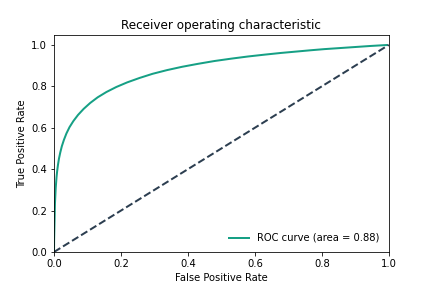

In [ ]:
evaluate(np.array(dists),np.array(dists2), thresholds_roc_start= 0.1, thresholds_roc_end=1.5,thresholds_roc_step=0.01, diagonal_excl=True)
Image.open('/content/roc.png')

#### MTCNN for LFW dataset

In [ ]:
data_dir = '/content/lfw'

MTCNN importing

In [ ]:
%cd '/content/InsightFace_Pytorch'
from mtcnn import MTCNN
mtcnn = MTCNN()
%cd ..

/content/InsightFace_Pytorch
/content


In [ ]:
def collate_fn(x):
    return x[0]

workers = 0 if os.name == 'nt' else 4

dataset = datasets.ImageFolder(data_dir)
dataset.idx_to_class = {i:c for c, i in dataset.class_to_idx.items()}
loader = DataLoader(dataset, collate_fn=collate_fn, num_workers=workers)

Aligned data preparation.

In [ ]:
aligned = []
names = []
trans = transforms.ToTensor()

for x, y in tqdm(loader):
  
  try:
    _, landmarks = mtcnn.detect_faces(x)
  except:
    landmarks = []

  if len(landmarks) != 0:
    x_aligned = mtcnn.align(x)
    aligned.append(trans(x_aligned))
    names.append(dataset.idx_to_class[y])

  0%|          | 0/13233 [00:00<?, ?it/s]/content/InsightFace_Pytorch/mtcnn_pytorch/src/matlab_cp2tform.py:90: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  r, _, _, _ = lstsq(X, U)
100%|██████████| 13233/13233 [10:26<00:00, 21.11it/s]


Number of photos after MTCNN application.

In [ ]:
len(names)

13059

#### Model validation results on LWE dataset

Calculating elements for evaluation metrices calculation.

In [ ]:
dists2 = [[e2==e1 for e2 in names] for e1 in tqdm(names)]

100%|██████████| 13059/13059 [00:09<00:00, 1366.71it/s]


In [ ]:
aligned = torch.stack(tuple(aligned)).to(device)

In [ ]:
dataset = aligned.clone()
batch_size = 1

In [ ]:
data_loader = DataLoader(
    dataset,
    batch_size=batch_size
)

In [ ]:
data_loader.dataset.size()

torch.Size([13059, 3, 112, 112])

Embedding calculation.

In [ ]:
mobilefacenet_v1.to(device).eval()

output_embeddings = []

for i, image in tqdm(enumerate(data_loader)):

  output = mobilefacenet_v1(image.to(device))

  norm_output = normalize(np.array(output[0].cpu()).reshape(1,-1), norm='l2', axis=1)
  output_embeddings.append(np.array(norm_output))

13059it [01:23, 156.17it/s]


In [ ]:
embeddings = torch.from_numpy(np.array(output_embeddings)).squeeze(1)

In [ ]:
len(output_embeddings)

13059

In [ ]:
dists = [[(e1 - e2).norm().item() for e2 in embeddings] for e1 in tqdm(embeddings)]

100%|██████████| 13059/13059 [44:08<00:00,  4.93it/s]


Calculating validation metrices.

the best accuracy: 0.9991613635259822 True Positive rate: 0.763983924369573 False Positive rate: 0.00017446053082483405 threshold: 0.78


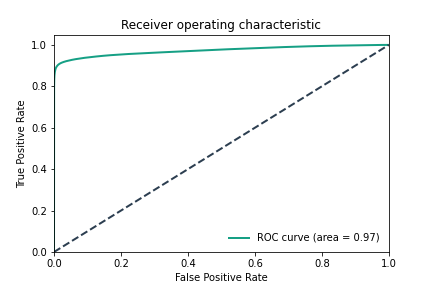

In [ ]:
evaluate(np.array(dists),np.array(dists2), thresholds_roc_start= 0.01, thresholds_roc_end=1.5, thresholds_roc_step=0.01, diagonal_excl=True)
Image.open('/content/roc.png')